In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import *

In [69]:
dir_csv = "ML_Intern_data.csv"
df = pd.read_csv(dir_csv)

In [70]:
df.head()

,date,da1_price
0,2021-01-01 00:00:00.000000 UTC,176.49
1,2021-01-01 01:00:00.000000 UTC,170.80
2,2021-01-01 02:00:00.000000 UTC,160.00
3,2021-01-01 03:00:00.000000 UTC,148.00
4,2021-01-01 04:00:00.000000 UTC,140.58


In [71]:
df = df.set_index('date')

In [72]:
df.head()

,da1_price
date,
2021-01-01 00:00:00.000000 UTC,176.49
2021-01-01 01:00:00.000000 UTC,170.80
2021-01-01 02:00:00.000000 UTC,160.00
2021-01-01 03:00:00.000000 UTC,148.00
2021-01-01 04:00:00.000000 UTC,140.58


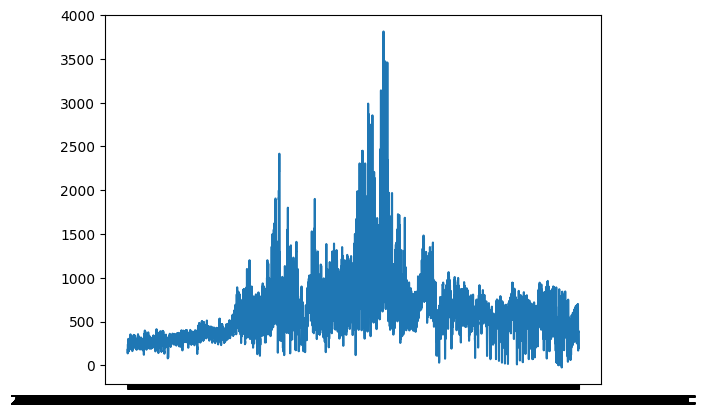

In [73]:
fig = plt.figure()
ax = plt.axes()

ax.plot(df.index, df['da1_price'])

In [74]:
# From the initial plot we could see that linear regression would be highly inefective here. 
# I think the best idea for now is to divide the plot, into three parts - old data, medium part (when prices are high) and newest one. Then we could maybe check seasonality. (now its not really visible)
# In the end there is some part that seems to be cyclic.
df.describe()

,da1_price
count,25365.000000
mean,572.220117
std,325.513728
min,-25.000000
25%,369.000000
50%,500.000000
75%,690.000000
max,3812.450000


In [75]:
# I can also add dummy variable indicating a step - then I will predict next 24 steps - 1 for each hour.
# As this is green energy it makes sense that there were some perdiods with very high values.
df['Time'] = np.arange(len(df.index))
df.head()

,da1_price,Time
date,,
2021-01-01 00:00:00.000000 UTC,176.49,0
2021-01-01 01:00:00.000000 UTC,170.80,1
2021-01-01 02:00:00.000000 UTC,160.00,2
2021-01-01 03:00:00.000000 UTC,148.00,3
2021-01-01 04:00:00.000000 UTC,140.58,4


In [76]:
# There is a possibility that pricing is seasonal, let's test for that.
df.index = pd.to_datetime(df.index)

In [81]:
df["week"] = df.index.isocalendar().week
df["day"] = df.index.dayofweek
df["year"] = df.index.year
df["quarter"] = df.index.quarter
df["month"] = df.index.month
df["hour"] = df.index.hour
df["day_of_year"] = df.index.dayofyear

In [82]:
df

,da1_price,Time,week,day,year,quarter,month,hour,day_of_year
date,,,,,,,,,
2021-01-01 00:00:00+00:00,176.49,0,53,4,2021,1,1,0,1
2021-01-01 01:00:00+00:00,170.80,1,53,4,2021,1,1,1,1
2021-01-01 02:00:00+00:00,160.00,2,53,4,2021,1,1,2,1
2021-01-01 03:00:00+00:00,148.00,3,53,4,2021,1,1,3,1
2021-01-01 04:00:00+00:00,140.58,4,53,4,2021,1,1,4,1
...,...,...,...,...,...,...,...,...,...
2023-11-23 19:00:00+00:00,374.00,25363,47,3,2023,4,11,19,327
2023-11-23 20:00:00+00:00,329.00,25364,47,3,2023,4,11,20,327
2023-11-23 21:00:00+00:00,250.00,25365,47,3,2023,4,11,21,327


In [83]:
df.describe()

,da1_price,Time,week,day,year,quarter,month,hour,day_of_year
count,25365.000000,25368.000000,25368.0,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000
mean,572.220117,12683.500000,25.738884,3.000000,2021.964049,2.456008,6.335856,11.500000,177.122044
std,325.513728,7323.255151,14.648737,2.000039,0.808342,1.099692,3.356779,6.922323,102.477414
min,-25.000000,0.000000,1.0,0.000000,2021.000000,1.000000,1.000000,0.000000,1.000000
25%,369.000000,6341.750000,13.0,1.000000,2021.000000,1.000000,3.000000,5.750000,89.000000
50%,500.000000,12683.500000,26.0,3.000000,2022.000000,2.000000,6.000000,11.500000,177.000000
75%,690.000000,19025.250000,38.0,5.000000,2023.000000,3.000000,9.000000,17.250000,265.000000
max,3812.450000,25367.000000,53.0,6.000000,2023.000000,4.000000,12.000000,23.000000,365.000000


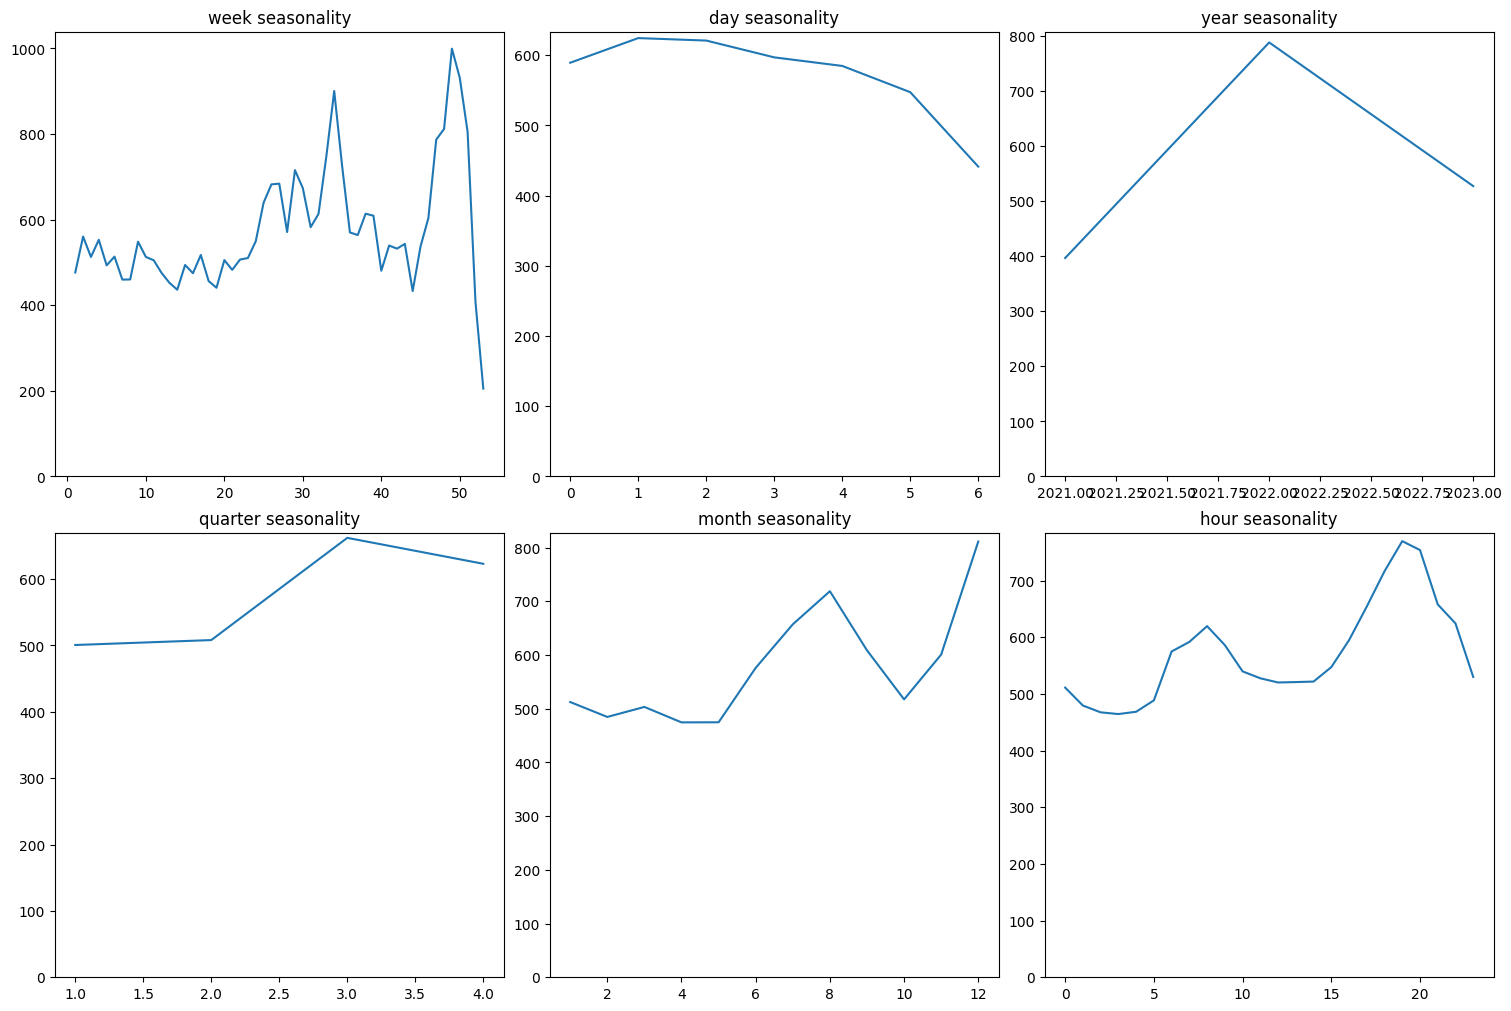

In [84]:
rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, constrained_layout=True, figsize=(15,10))
i=0
for col in df.columns.drop(['da1_price', 'Time','day_of_year']):
    i+=1
    ax = plt.subplot(rows, cols,i)
    df.groupby(col)['da1_price'].mean().plot()
    ax.set_ylim(ymin=0)
    ax.set_xlabel(None)
    ax.set_title(f'{col} seasonality')
    

In [85]:
# we can see that in 1 year prices increased significantly. 
# Weekly seasonality is quite strange, there is 1 above 30 that prices are high (maybe it has to do with exogenous variables). Like information from government?
# Monthly is similar to weekly, just divided over 12 not 52.
# We can see that during week starting from Sunday prices are high and then slowly decreases. The lowest prices are on Sunday.
# Quarter seasonality somehow reflect weekly and monthly - highest 3rd and 4th.
# Hourly seasonality interests us, because we have to predict next 24-hours. We can notice high price when market opens - 8.00 and starts going up when market closes - 15.30.
# I have no idea why in the evening price is so high, but market does not work, so...

In [86]:
# Let's try to analize only last part of diagram (when prices did not skyrocket). We will focus on daily / hourly predictions.
df_splitted = np.array_split(df, 3)
df_splitted[2]

,da1_price,Time,week,day,year,quarter,month,hour,day_of_year
date,,,,,,,,,
2022-12-06 16:00:00+00:00,1248.29,16912,49,1,2022,4,12,16,340
2022-12-06 17:00:00+00:00,1190.00,16913,49,1,2022,4,12,17,340
2022-12-06 18:00:00+00:00,1140.00,16914,49,1,2022,4,12,18,340
2022-12-06 19:00:00+00:00,1106.13,16915,49,1,2022,4,12,19,340
2022-12-06 20:00:00+00:00,1014.66,16916,49,1,2022,4,12,20,340
...,...,...,...,...,...,...,...,...,...
2023-11-23 19:00:00+00:00,374.00,25363,47,3,2023,4,11,19,327
2023-11-23 20:00:00+00:00,329.00,25364,47,3,2023,4,11,20,327
2023-11-23 21:00:00+00:00,250.00,25365,47,3,2023,4,11,21,327


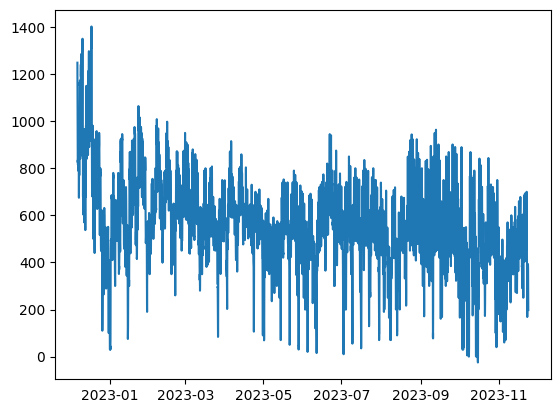

In [87]:
fig = plt.figure()
ax = plt.axes()

ax.plot(df_splitted[2].index, df_splitted[2]['da1_price'])

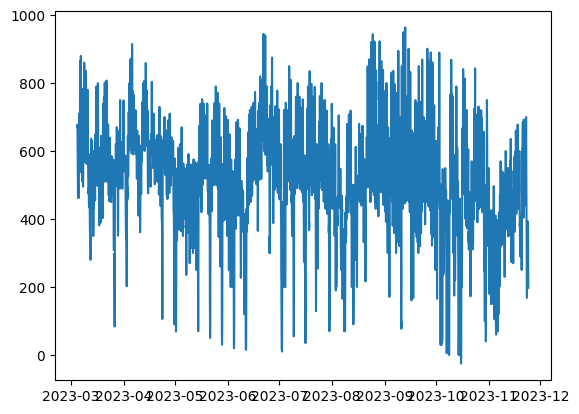

In [88]:
df_splitted_4 = np.array_split(df, 4)
fig = plt.figure()
ax = plt.axes()

ax.plot(df_splitted_4[3].index, df_splitted_4[3]['da1_price'])

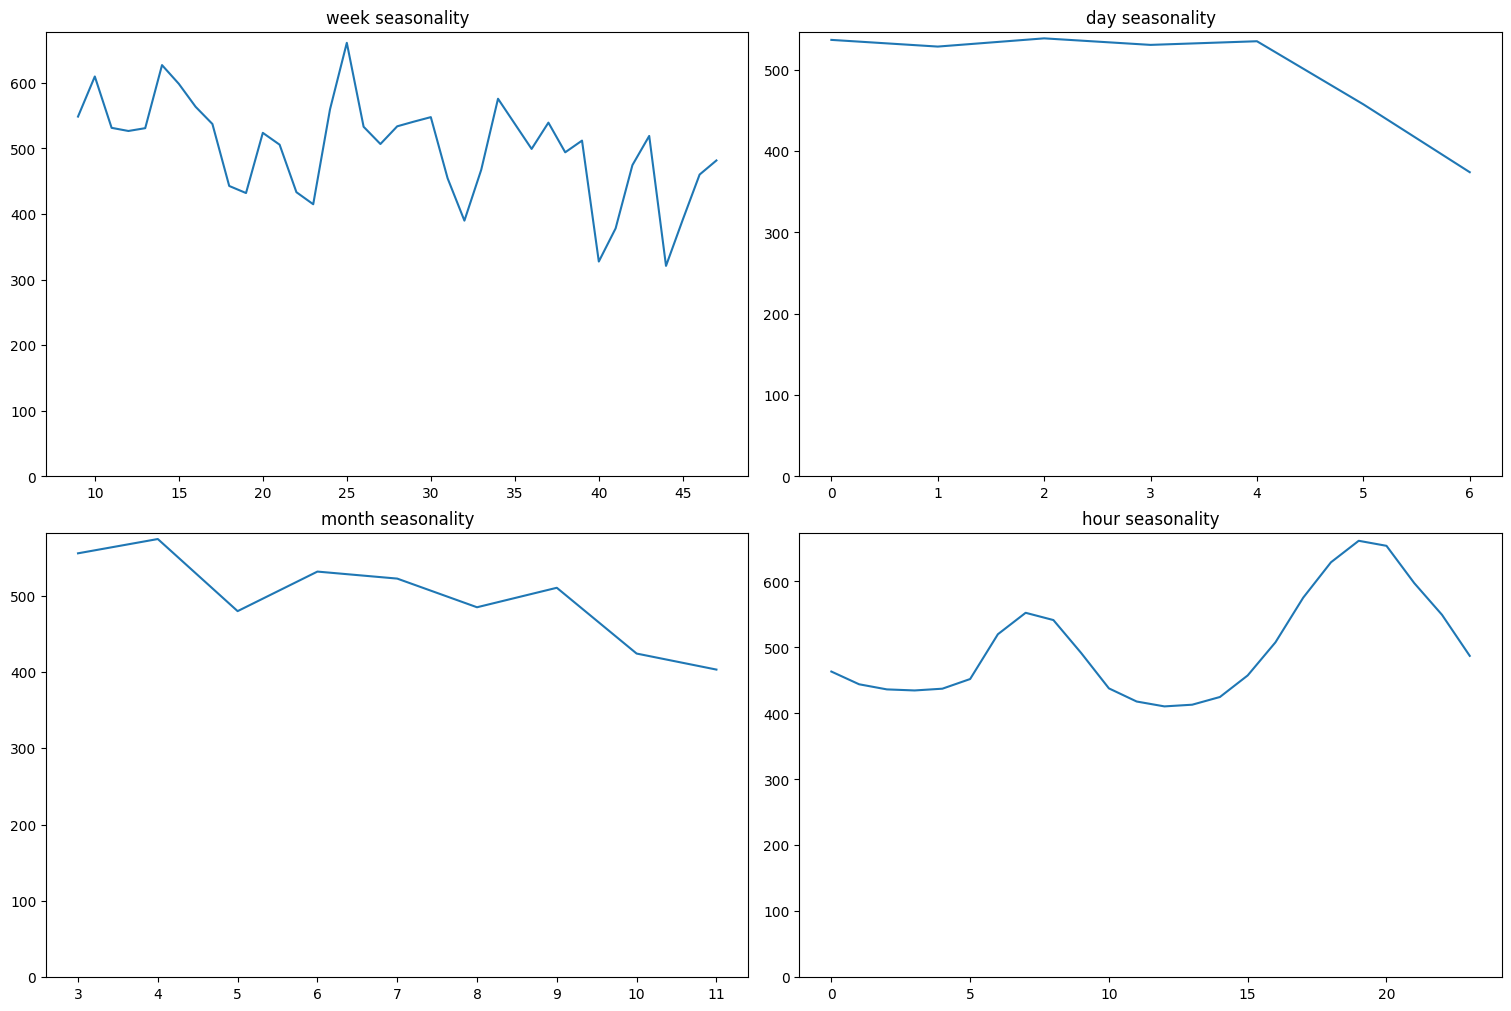

In [90]:
# I think it will be easier to analize prices from this year only since March. As we can notice the prices are quite similar, there is no trend. Let's test for seasonality:
# (Let's ommit year and quarter, it gives too less info)
rows = 2
cols = 2
fig, axs = plt.subplots(rows, cols, constrained_layout=True, figsize=(15,10))
i=0
for col in df_splitted_4[3].columns.drop(['da1_price', 'Time','year','quarter','day_of_year']):
    i+=1
    ax = plt.subplot(rows, cols,i)
    df_splitted_4[3].groupby(col)['da1_price'].mean().plot()
    ax.set_ylim(ymin=0)
    ax.set_xlabel(None)
    ax.set_title(f'{col} seasonality')

In [91]:
# As we can see for weekly and monthly newest data is not really seasonal. But we can use hourly and daily seasonalities, they are the same as for a whole data.
# Maybe let's just use hourly by now. I will try to model seasonal variation with Fourier Series.
# Or different approach - let's try Seasonal ARIMA model. I am already familiar with simple ARIMA so it should not be that hard.
# After creating this I will fill it maybe with newest data from the site. Then create it again with new train - validation - test split.

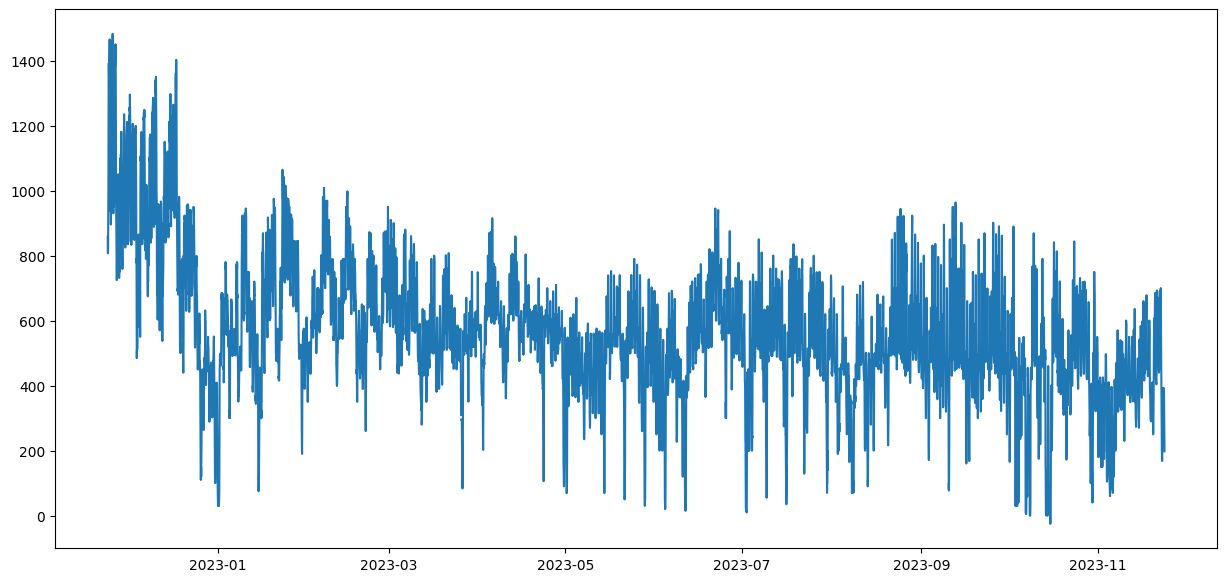

In [92]:
# let's try to work on one year period of time. Let's work on that, because here we have some colder months in winter.
df_one_year = df.loc[(df.index >= '2022-11-24 00:00:00+00:00')]
fig = plt.figure(1, (15,7))
ax = plt.axes()

ax.plot(df_one_year.index, df_one_year['da1_price'])

In [93]:
# last 2 months will be our test set
train_one_year = df_one_year.loc[(df_one_year.index < '2023-09-25 00:00:00+00:00')]


In [143]:
test_one_year = df_one_year.loc[(df_one_year.index >= '2023-09-25 00:00:00+00:00')]

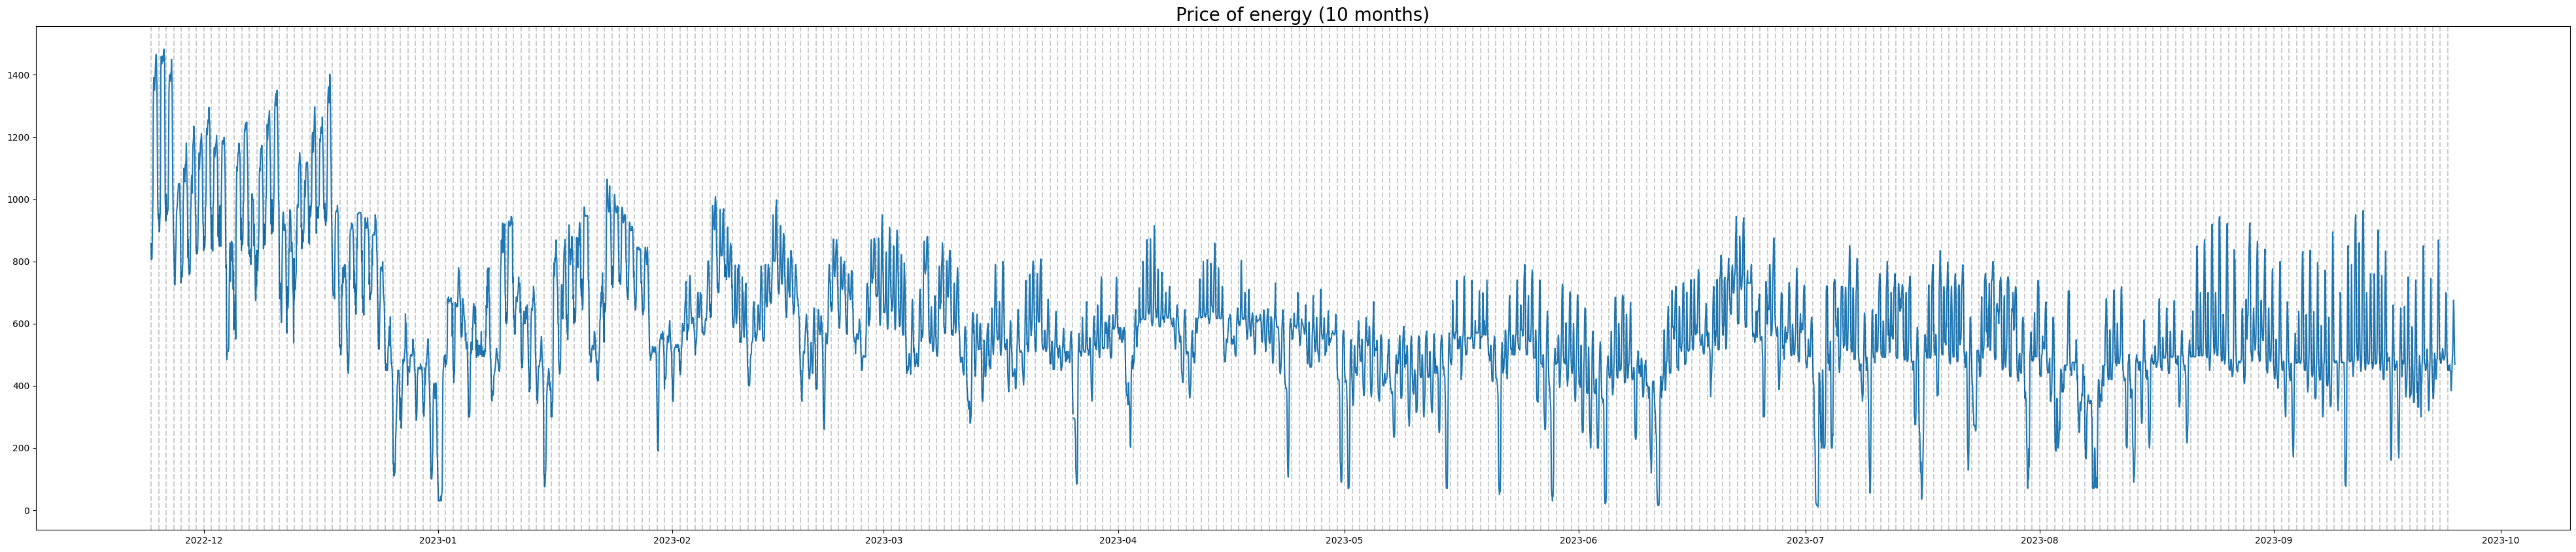

In [111]:
plt.figure(figsize=(50,10))
plt.plot(train_one_year.index, train_one_year['da1_price'])
plt.title('Price of energy (10 months)', fontsize=20)
for day in np.unique(train_one_year.index.date):
    plt.axvline(pd.to_datetime(str(day)), color='k', linestyle='--', alpha=0.2)

In [112]:
# When we expand an image we can clearly see that during night/evening price drops, so we have some pattern. Let's try it out.
# let's calculate difference between consecutive rows
first_diff = train_one_year['da1_price'].diff()[1:]


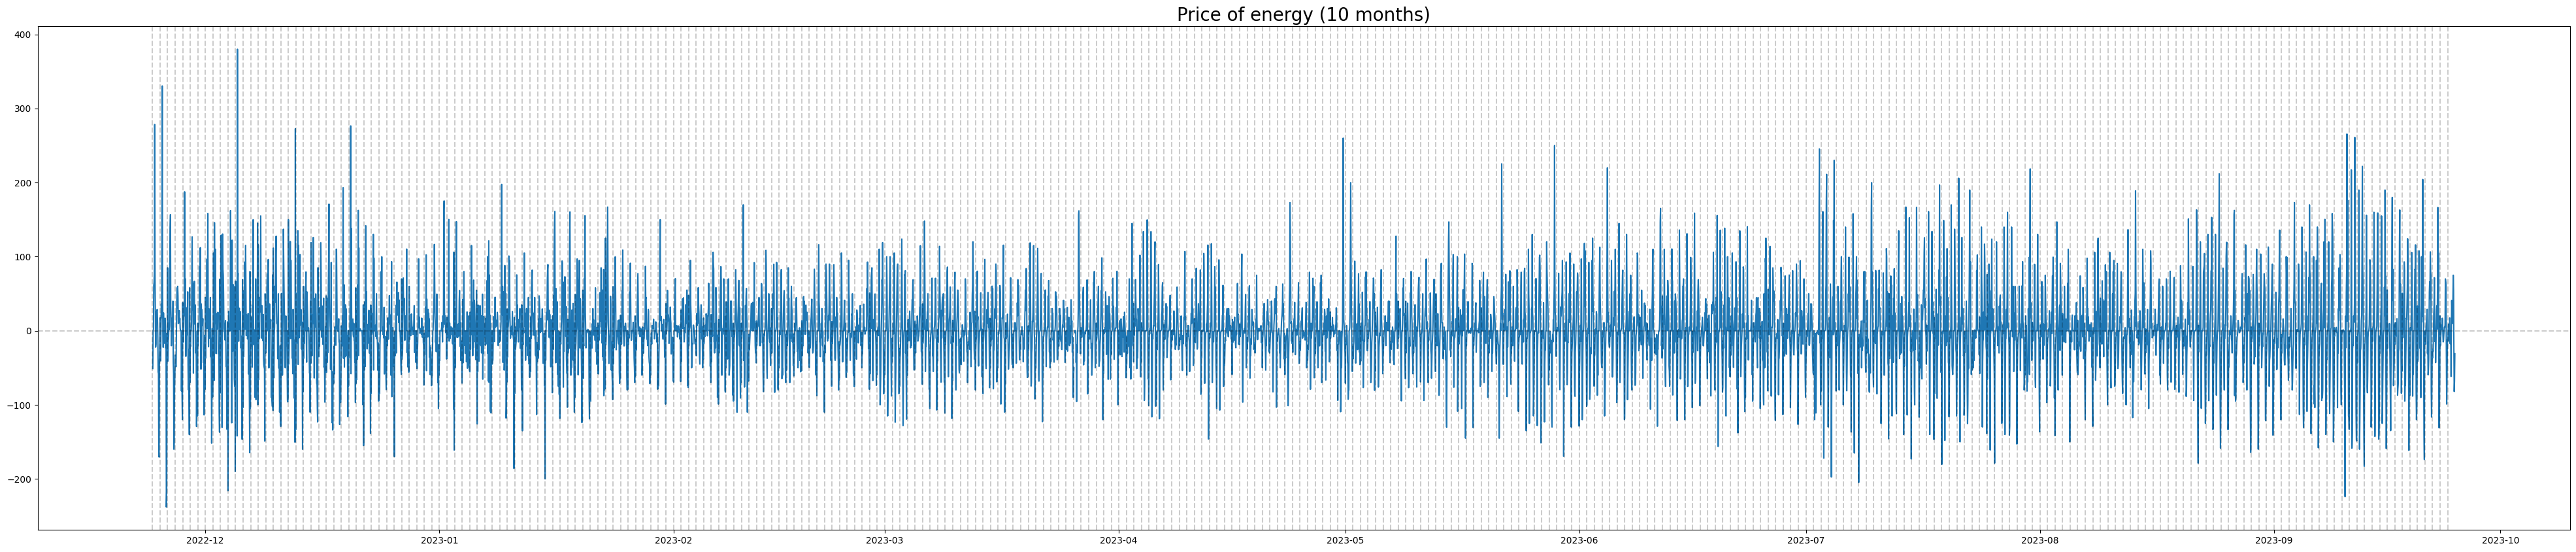

In [115]:
plt.figure(figsize=(50,10))
plt.plot(first_diff)
plt.title('Price of energy (10 months)', fontsize=20)
for day in np.unique(train_one_year.index.date):
    plt.axvline(pd.to_datetime(str(day)), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

In [139]:
# We can see daily patterns, but I do not think now that SARIMA model is the best. Then we would not use endogenous features. I will try with probably LSTM next. 
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 305)
# define model

model = SARIMAX(train_one_year['da1_price'], order=my_order, seasonal_order=my_seasonal_order, freq='H')

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [141]:

#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 1159.2471265792847


In [142]:
print(model_fit.summary())

                                       SARIMAX Results                                       
Dep. Variable:                             da1_price   No. Observations:                 7320
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 305)   Log Likelihood              -38900.264
Date:                               Tue, 05 Dec 2023   AIC                          77806.529
Time:                                       01:19:29   BIC                          77827.224
Sample:                                   11-24-2022   HQIC                         77813.644
                                        - 09-24-2023                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L305     -0.2281      0.042     -5.463      0.000      -0.310      -0.146
ma.S.L305  

In [147]:
predictions = model_fit.forecast(len(test_one_year))
predictions = pd.Series(predictions, index=test_one_year.index)


In [148]:
predictions

date
2023-09-25 00:00:00+00:00    435.853007
2023-09-25 01:00:00+00:00    483.997332
2023-09-25 02:00:00+00:00    520.099309
2023-09-25 03:00:00+00:00    541.711999
2023-09-25 04:00:00+00:00    548.306483
                                ...    
2023-11-23 19:00:00+00:00    534.851654
2023-11-23 20:00:00+00:00    534.827891
2023-11-23 21:00:00+00:00    534.849777
2023-11-23 22:00:00+00:00    534.858431
2023-11-23 23:00:00+00:00    534.897736
Name: predicted_mean, Length: 1440, dtype: float64

In [153]:
residuals = test_one_year['da1_price'] - predictions
residuals

date
2023-09-25 00:00:00+00:00     34.146993
2023-09-25 01:00:00+00:00    -27.557332
2023-09-25 02:00:00+00:00    -70.099309
2023-09-25 03:00:00+00:00    -91.711999
2023-09-25 04:00:00+00:00    -93.416483
                                ...    
2023-11-23 19:00:00+00:00   -160.851654
2023-11-23 20:00:00+00:00   -205.827891
2023-11-23 21:00:00+00:00   -284.849777
2023-11-23 22:00:00+00:00   -309.858431
2023-11-23 23:00:00+00:00   -337.197736
Length: 1440, dtype: float64

In [157]:
residuals24h = test_one_year['da1_price'][:24] - predictions[:24]

In [159]:
# Here we have predictions for 24 hours. 
# SARIMA model was modelled badly in general. Didn't check for stationarity, didn't test out new parameters, but making it does not make sense in general. 
# I want to use other data as well, so will create LSTM instead.
residuals24h

date
2023-09-25 00:00:00+00:00     34.146993
2023-09-25 01:00:00+00:00    -27.557332
2023-09-25 02:00:00+00:00    -70.099309
2023-09-25 03:00:00+00:00    -91.711999
2023-09-25 04:00:00+00:00    -93.416483
2023-09-25 05:00:00+00:00    -74.189156
2023-09-25 06:00:00+00:00     35.035024
2023-09-25 07:00:00+00:00    136.540587
2023-09-25 08:00:00+00:00    120.178759
2023-09-25 09:00:00+00:00     50.375317
2023-09-25 10:00:00+00:00     46.941526
2023-09-25 11:00:00+00:00     68.123049
2023-09-25 12:00:00+00:00     87.960671
2023-09-25 13:00:00+00:00     88.132220
2023-09-25 14:00:00+00:00     71.905699
2023-09-25 15:00:00+00:00    123.231662
2023-09-25 16:00:00+00:00    120.302645
2023-09-25 17:00:00+00:00    201.849046
2023-09-25 18:00:00+00:00    337.982653
2023-09-25 19:00:00+00:00    342.834692
2023-09-25 20:00:00+00:00    319.757607
2023-09-25 21:00:00+00:00    174.019927
2023-09-25 22:00:00+00:00     31.110858
2023-09-25 23:00:00+00:00     -4.230708
dtype: float64

Text(0, 0.5, 'Error')

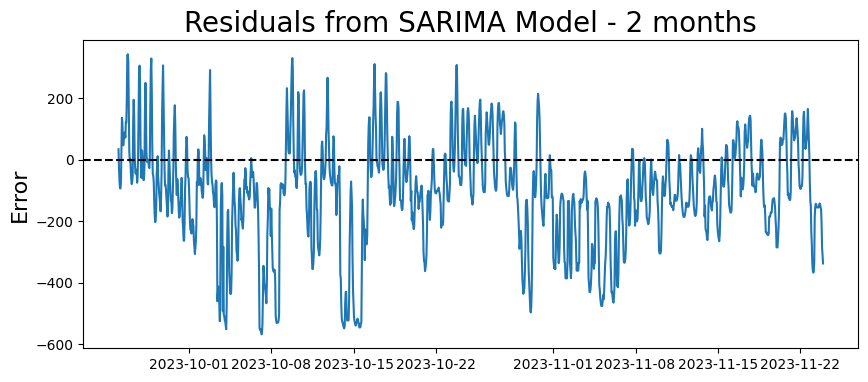

In [161]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model - 2 months', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Error')

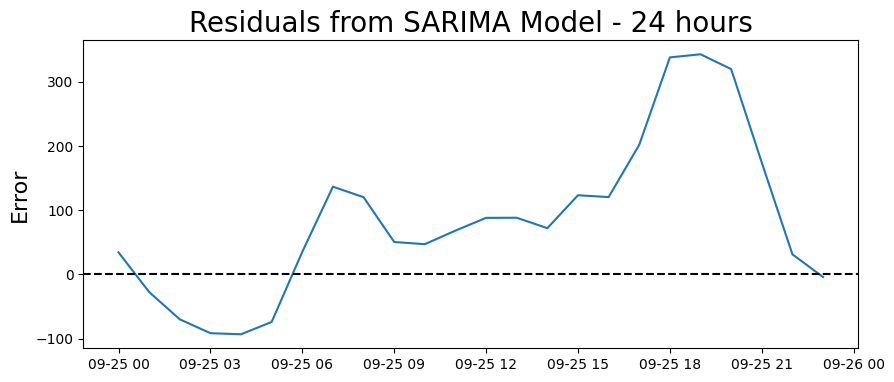

In [162]:
plt.figure(figsize=(10,4))
plt.plot(residuals24h)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model - 24 hours', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [163]:
# No need to comment that. Probably did too many cycles while modelling and everything collapsed. 
# Badly designed, but let's forget this idea.
# Let's focus on LSTM. I could do moving average, but with this drastic change it makes no sense.